# Point operations
In this notebook we show some homogeneneous point operations. They depends only on one pixel and not on any other neighbor pixel.

In [27]:
import numpy as np
import skimage
from skimage import io
from skimage import util
import matplotlib.pyplot as plt

## Contrast and brightness

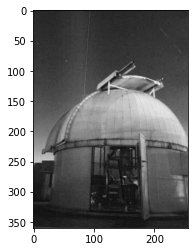

In [2]:
lidar = io.imread('images/lidar.png')[:,:,0] # use only one channel
rows, cols = lidar.shape 
plt.imshow(lidar, cmap='gray')

In [3]:
def dip_setContrastBrightness(image, contrast, brightness):
    rows, cols = image.shape
    image_cb = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            vcb = contrast * v + brightness
            if vcb > 255: vcb = 255
            image_cb[row, col] = vcb
    return image_cb        

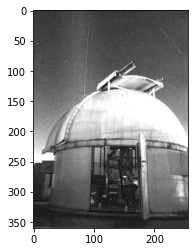

In [4]:
lidar_cb = dip_setContrastBrightness(lidar, 1.5, 10)
plt.imshow(lidar_cb, cmap='gray')

## Image inversion

In [5]:
def dip_invert(image):
    rows, cols = image.shape
    inverted_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            inverted_image[row, col] = 255 - v
    return inverted_image

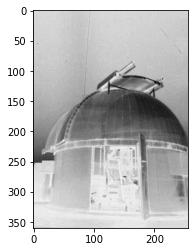

In [6]:
lidar_inv = dip_invert(lidar)
plt.imshow(lidar_inv, cmap='gray')

We show how the inversion operation affects the histogram of the image

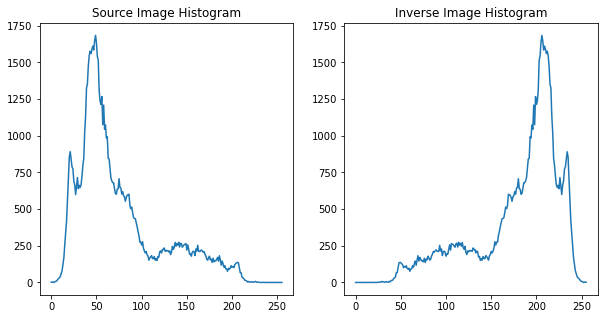

In [8]:
from ipynb.fs.full.histograms import dip_histogram
histogram = dip_histogram(lidar)
inverse_histogram = dip_histogram(lidar_inv)
x =np.arange(0, 256, 1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.set_title('Source Image Histogram')
ax1.plot(x, histogram)
ax2.set_title('Inverse Image Histogram')
ax2.plot(x, inverse_histogram)

The same result can be obtained using the scikit-image function for [image inversion](https://scikit-image.org/docs/dev/user_guide/transforming_image_data.html?highlight=inversion#image-inversion)

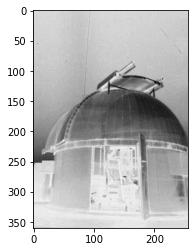

In [9]:
inverted_lidar = util.invert(lidar)
plt.imshow(inverted_lidar, cmap='gray')

## Thresholding
Thresholding is used to create a binary image from a grayscale image.

In [10]:
def dip_threshold(image):
    threshold = 128
    rows, cols = image.shape
    threshold_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            if v > threshold:
                threshold_image[row, col] = 200
            else:
                threshold_image[row, col] = 50
    return threshold_image

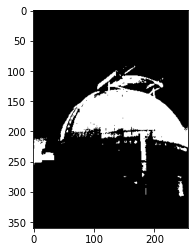

In [11]:
lidar_thr = dip_threshold(lidar)
plt.imshow(lidar_thr, cmap='gray')

After the thresholding the histogram of the image has only two entries

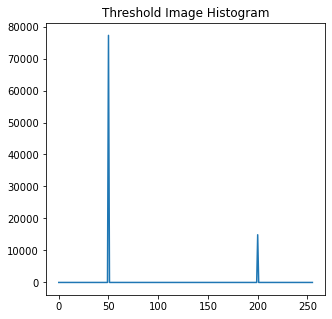

In [12]:
hist_threshold = dip_histogram(lidar_thr)
x =np.arange(0, 256, 1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title('Threshold Image Histogram')
plt.plot(x, hist_threshold)

scikit-image provides more sophisticated [thresholding functions](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html)

## Histogram equalization

The purpose of the equalization is to find a point operation that transforms the value of each pixel of a source image in  such a way that the histogram of the equalized image becomes approximately uniformly distributed or in other words, so that each pixel value of the equalized image occurs the same number of times. The histogram of the equalized image is also called the reference histogram. It is clear that we have to apply the same point transformation to all the pixels of the source image that share the same value v so that they get the value v' in the equalized image. One easy way would be to use the histogram of the source image $h(v)$ and the histogram of the equalized image $h_e(v')$ so that 

$$h(v) = h_e(v')$$

from which we could compute the value v' of the equalized image that corresponds to the value v of the source image

$$v' = h_e^{-1}(h(v))$$

the problem is that there might be more then one value v with the same histogram h(v) so it won't be clear to which we have to apply the inverse operation $h_e^{-1}$. We can avoid this problem by using the cumulative histograms that are always monotonic and for which there is only one value for the inverse. So we use the condition

$$H(v) = H_e(v')$$

from which in a similar way as before we get the value v'

$$v' = H_e^{-1}(H(v))$$

Let's assume for simplicity that the size of our source image is MxN and that the range of its pixel values is [0, 255]. By definition of cumulative histogram

$$H(255) = H_e(255) = MN$$

We can also assume that $H(0) = H_e(0) = 0$. Since the cumulative histogram of the equalized image is linear we have

$$H_e(v') = \frac{MN}{255}v' = H(v)$$

from which we can compute the value v' of the equalized image to which the value v of the source image must be mapped.

$$v' = \frac{255}{MN}H(v)$$

We can easily translate the math into code 

In [13]:
img = skimage.data.moon()
from ipynb.fs.full.histograms import dip_cumulativeHistogram
img_histogram = dip_histogram(img)
img_cumulative_hist = dip_cumulativeHistogram(img_histogram)

In [14]:
def dip_equalize(image, cumulative_histogram):
    rows, cols = image.shape
    equalized_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            equalized_image[row, col] = cumulative_histogram[v] * 255 / (rows * cols)
    return equalized_image

<Figure size 720x360 with 0 Axes>

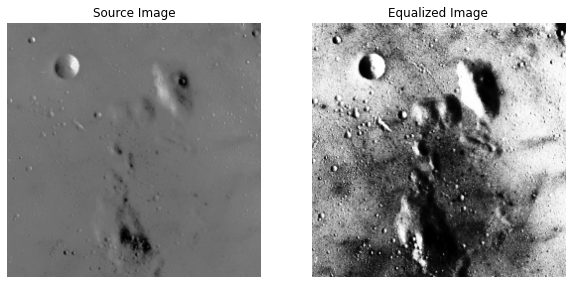

In [15]:
img_equalized = dip_equalize(img, img_cumulative_hist)
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('Source Image')
ax1.imshow(img, cmap='gray')
ax2.set_title('Equalized Image')
ax2.imshow(img_equalized, cmap='gray')

The cumulative histogram of the equalized image should be linear

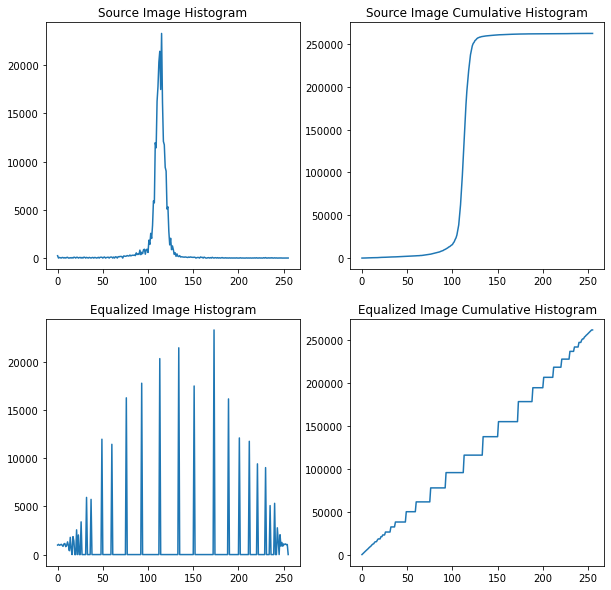

In [16]:
img_eq_histogram = dip_histogram(img_equalized)
img_eq_cumulative_histogram = dip_cumulativeHistogram(img_eq_histogram)
x =np.arange(0, 256, 1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes[0,0].set_title('Source Image Histogram')
axes[0,0].plot(x, img_histogram)
axes[0,1].set_title('Source Image Cumulative Histogram')
axes[0,1].plot(x, img_cumulative_hist)
axes[1,0].set_title('Equalized Image Histogram')
axes[1,0].plot(x, img_eq_histogram)
axes[1,1].set_title('Equalized Image Cumulative Histogram')
axes[1,1].plot(x, img_eq_cumulative_histogram)

scikit-image provides two functions for [histogram equalization](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html)

## Histogram matching
We may be interested in changing the distribution of the pixels' values of an image to be equal to the distribution of a reference image (see also the scikit-image documentation about [histogram matching](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_histogram_matching.html). We'll follow the same approach used for image equalization the sole difference being that the reference cumulative distribution generally will not be linear. Since the size of the two images are generally different we'll use the probability distributions instead of the histograms and the cumulative probability distributions instead of the cumulative histograms. 

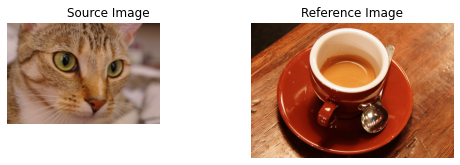

In [17]:
reference_img = skimage.data.coffee()
source_img = skimage.data.chelsea()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharex=True, sharey=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('Source Image')
ax1.imshow(source_img)
ax2.set_title('Reference Image')
ax2.imshow(reference_img)

We start by looking at the probability and cumulative distributions of the source and reference image, taking into account that they are color images and so we have to consider each channel separately.

In [18]:
from ipynb.fs.full.histograms import dip_image_cumulative_dist
from ipynb.fs.full.histograms import dip_image_dist
from ipynb.fs.full.histograms import dip_rgb_image_dist
from ipynb.fs.full.histograms import dip_rgb_image_cumulative_dist
source_dist = dip_rgb_image_dist(source_img)
source_cdf = dip_rgb_image_cumulative_dist(source_img)
reference_dist = dip_rgb_image_dist(reference_img)
reference_cdf = dip_rgb_image_cumulative_dist(reference_img)

We plot the probability and cumulative distribution for only one channel of the source image

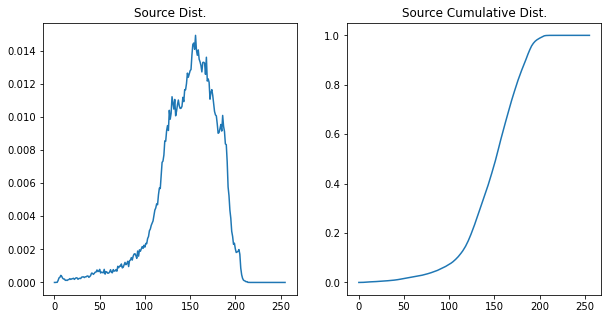

In [21]:
x =np.arange(0, 256, 1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.set_title('Source Dist.')
ax1.plot(x, source_dist[0])
ax2.set_title('Source Cumulative Dist.')
ax2.plot(x, source_cdf[0])

and the same for the reference image

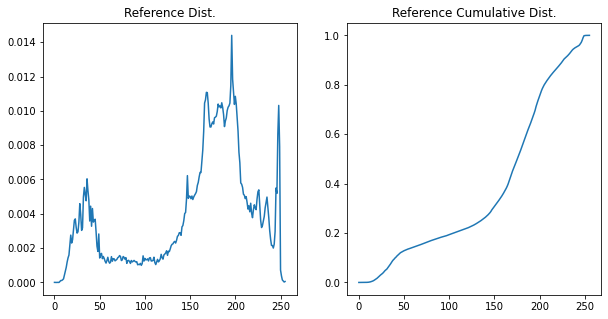

In [20]:
x =np.arange(0, 256, 1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.set_title('Reference Dist.')
ax2.set_title('Reference Cumulative Dist.')
ax1.plot(x, reference_dist[0])
ax2.plot(x, reference_cdf[0])

The difference between the equalization case and the histogram matching is that we cannot assume the reference cumulative distribution to be linear so we have to compute the inverse of the reference cumulative distribution

$$v' = H_r^{-1}(H(v))$$


For each pixel value v 
1. we find the source cumulative probability (e.g. v=144 -> cds(144) = 0.4)
2. we find the reference pixel value v' that has the same probability (e.g. v'=165 -> cdr(165) = 0.4)
3. we set the  pixel value of the matched image to the reference value (e.g. from 144 to 165)

Step 2 means that we have to find the inverse of the reference cumulative distribution.

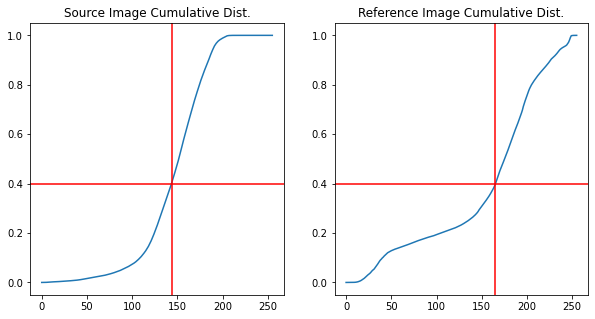

In [41]:
x =np.arange(0, 256, 1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.set_title('Source Image Cumulative Dist.')
ax1.plot(x, source_cdf[0])
ax2.set_title('Reference Image Cumulative Dist.')
ax2.plot(x, reference_cdf[0])
ax1.axhline(y=0.4, color='r', linestyle='-')
ax2.axhline(y=0.4, color='r', linestyle='-')
ax1.axvline(x=144, color='r', linestyle='-')
ax2.axvline(x=165, color='r', linestyle='-')

In [ ]:
def dip_match_histogram(image, cumulative_histogram):
    rows, cols = image.shape
    matched_image = np.zeros((rows, cols), dtype=int)
    for col in np.arange(0, cols, 1):
        for row in np.arange(0, rows, 1):
            v = image[row, col]
            matched_image[row, col] = cumulative_histogram[v] * 255 / (rows * cols)
    return equalized_image